# Overview

Can a computer "learn" to classify artists by their paintings? 

ResNet50 is a good model for classifying ImageNet data. How about a set of 38 artists?

We use transfer learning to re-train a ResNet50 model to identify one of 38 artists who have more than ~~300~~ ***200*** paintings in the dataset. 

This notebook is part of a project for CSC 480 taught by [Dr. Franz J. Kurfess](http://users.csc.calpoly.edu/~fkurfess/) at Cal Poly

A web application is [in development](https://github.com/SomethingAboutImages/WebImageClassifier) to make use of the model that this notebook outputs. 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# %matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info

import gc # garbage collection

In [2]:
MY_SEED = 42 # 480 could work too
seed(MY_SEED)
np.random.seed(MY_SEED)
tensorflow.random.set_seed(MY_SEED)

print(sys_info())
# get module information
%pip freeze > frozen-requirements.txt
# append system information to file
with open("frozen-requirements.txt", "a") as file:
    file.write(sys_info())

{'commit_hash': '3427ce7',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/anaconda/envs/myenv/lib/python3.12/site-packages/IPython',
 'ipython_version': '8.24.0',
 'os_name': 'posix',
 'platform': 'Linux-5.15.0-1063-azure-x86_64-with-glibc2.31',
 'sys_executable': '/anaconda/envs/myenv/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.12.3 | packaged by conda-forge | (main, Apr 15 2024, '
                '18:38:13) [GCC 12.3.0]'}
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install -r '/home/xnmaster/Project/XNAPproject-grup07/our_code/frozen-requirements.txt' #"C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\our_code\frozen-requirements.txt"

In [ ]:
# %pip install tensorflow[and-cuda]

In [3]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12788354935480529043
xla_global_id: -1
]


In [4]:
# https://stackoverflow.com/questions/25705773/image-cropping-tool-python
# because painting images are hella big
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [ ]:
%pip install Pillow --upgrade

In [29]:
# globals

DATA_DIR = '/home/xnmaster/Project/input' # r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input" 
TRAIN_1_DIR =  '/home/xnmaster/Project/input/train_1' # r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\train_1\train_1"
# TRAIN_2_DIR = '../input/painters-train-part-1/train_2/train_2/'
# TRAIN_3_DIR = '../input/painters-train-part-1/train_3/train_3/'

# TRAIN_4_DIR = '../input/painters-train-part-2/train_4/train_4/'
# TRAIN_5_DIR = '../input/painters-train-part-2/train_5/train_5/'
# TRAIN_6_DIR = '../input/painters-train-part-2/train_6/train_6/'

# TRAIN_7_DIR = '../input/painters-train-part-3/train_7/train_7/'
# TRAIN_8_DIR = '../input/painters-train-part-3/train_8/train_8/'
# TRAIN_9_DIR = '../input/painters-train-part-3/train_9/train_9/'

# TRAIN_DIRS = [TRAIN_1_DIR, TRAIN_2_DIR, TRAIN_3_DIR,
#              TRAIN_4_DIR, TRAIN_5_DIR, TRAIN_6_DIR,
#              TRAIN_7_DIR, TRAIN_8_DIR, TRAIN_9_DIR]

TRAIN_DIRS = [TRAIN_1_DIR]
TEST_DIR = '/home/xnmaster/Project/input/test' # r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\test\test" 

In [40]:
from PIL import Image
import os

# Function to check if a file is an image
def is_image(file_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    return any(file_path.lower().endswith(ext) for ext in image_extensions)

# Function to check if an image file is valid
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception as e:
        print(f"Invalid image: {file_path} - {e}")
        # Remove the file if it's invalid
        os.remove(file_path)
        print(f"Removed file: {file_path}")
        return False

# Validate images in a directory
def validate_images(directory):
    print(f"Validating images in directory: {directory}")
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and is_image(file_path):
            if is_valid_image(file_path):
                print(f"Valid image: {file_path}")

# Validate training and testing directories
def validate_directories(*directories):
    for directory in directories:
        if not os.path.exists(directory):
            raise ValueError(f"Directory does not exist: {directory}")
        if not os.path.isdir(directory):
            raise ValueError(f"Not a directory: {directory}")

# Validate training and testing directories
validate_directories(DATA_DIR, TEST_DIR)
for train_dir in TRAIN_DIRS:
    validate_directories(train_dir)

# Validate images in training and testing directories
validate_images(DATA_DIR)
validate_images(TEST_DIR)
for train_dir in TRAIN_DIRS:
    validate_images(train_dir)


Validating images in directory: /home/xnmaster/Project/input
Validating images in directory: /home/xnmaster/Project/input/test
Valid image: /home/xnmaster/Project/input/test/24002.jpg
Valid image: /home/xnmaster/Project/input/test/73811.jpg
Valid image: /home/xnmaster/Project/input/test/67468.jpg
Valid image: /home/xnmaster/Project/input/test/1174.jpg
Valid image: /home/xnmaster/Project/input/test/25904.jpg
Valid image: /home/xnmaster/Project/input/test/39368.jpg
Valid image: /home/xnmaster/Project/input/test/25547.jpg
Valid image: /home/xnmaster/Project/input/test/69260.jpg
Valid image: /home/xnmaster/Project/input/test/64880.jpg
Valid image: /home/xnmaster/Project/input/test/1206.jpg
Valid image: /home/xnmaster/Project/input/test/20127.jpg
Valid image: /home/xnmaster/Project/input/test/29973.jpg
Valid image: /home/xnmaster/Project/input/test/22060.jpg
Valid image: /home/xnmaster/Project/input/test/62874.jpg
Valid image: /home/xnmaster/Project/input/test/33899.jpg
Valid image: /home/x

In [41]:
df = pd.read_csv(DATA_DIR + '/all_data_info/all_data_info.csv') # r'\train_info\train_info.csv'
print("df.shape", df.shape)

df.shape (79433, 6)


In [42]:
df.head()

,filename,artist,title,style,genre,date
0,102257.jpg,5b39c876740bfc1cfaf544721c43cac3,Uriel,Color Field Painting,abstract,1955.0
1,75232.jpg,5b39c876740bfc1cfaf544721c43cac3,Vir Heroicus Sublimis,Color Field Painting,abstract,1950.0
2,29855.jpg,96e5bc98488ed589b9bf17ad9fd09371,Night March of a Hundred Demons (left half),Yamato-e,mythological painting,NaN
3,62252.jpg,5b39c876740bfc1cfaf544721c43cac3,"Who’s Afraid of Red, Yellow and Blue II",Color Field Painting,abstract,NaN
4,63861.jpg,5b39c876740bfc1cfaf544721c43cac3,Black Fire I,Color Field Painting,abstract,1963.0


In [43]:
# quick fix for corrupted files
list_of_corrupted = ['3917.jpg','18649.jpg','20153.jpg','41945.jpg',
'79499.jpg','91033.jpg','92899.jpg','95347.jpg',
'100532.jpg','101947.jpg']
# display the corrupted rows of dataset for context
corrupt_df = df[df["new_filename"].isin(list_of_corrupted) == True]
print(corrupt_df.head(len(list_of_corrupted)))

# completely get rid of them
df = df[df["new_filename"].isin(list_of_corrupted) == False]

# try to see if they are still there
print(df[df["new_filename"].isin(list_of_corrupted) == True])

print("df.shape", df.shape)

         filename                            artist  \
520     41945.jpg  c7410238d399d9f454123e59b059fdd2   
722    101947.jpg  c7410238d399d9f454123e59b059fdd2   
793     95347.jpg  be8c592032dde81ef7e4247e3c7b5beb   
7649    91033.jpg  be8c592032dde81ef7e4247e3c7b5beb   
15230   79499.jpg  95170250b9a5101b11db6d60acfc9f86   
35511   92899.jpg  6e995a98857a349071182cf6c713e35f   
75522    3917.jpg  f7b0b8b497d3e489bd836159807ba906   

                                                   title         style  \
520                                Landscape at Beaulieu        Cubism   
722                                     Glass and carafe        Cubism   
793                                Robin of Modern Times   Romanticism   
7649                                Thoughts of the Past   Romanticism   
15230                                     Special No. 32  Abstract Art   
35511  A landscape with travellers crossing a bridge ...       Baroque   
75522                                   C

In [44]:
test_df = df[['artist', 'new_filename']]
print("test_df.shape", test_df.shape)

test_df.shape (79426, 2)


In [45]:
test_df.head()

,artist,filename
0,5b39c876740bfc1cfaf544721c43cac3,102257.jpg
1,5b39c876740bfc1cfaf544721c43cac3,75232.jpg
2,96e5bc98488ed589b9bf17ad9fd09371,29855.jpg
3,5b39c876740bfc1cfaf544721c43cac3,62252.jpg
4,5b39c876740bfc1cfaf544721c43cac3,63861.jpg


In [46]:
train_df = df[df["in_train"] == True]
test_df = df[df['in_train'] == False]
train_df = df[['artist', 'new_filename']]
# test_df = test_df[['artist', 'new_filename']]

# print("test_df.shape", test_df.shape)
print("train_df.shape", train_df.shape)

artists = {} # holds artist hash & the count
for a in train_df['artist']:
    if (a not in artists):
        artists[a] = 1
    else:
        artists[a] += 1

training_set_artists = []
for a,count in artists.items():
    if(int(count) >= 200):
        training_set_artists.append(a)

print("number of artists",len(training_set_artists))

print("\nlist of artists...\n", training_set_artists)


train_df.shape (79426, 2)
number of artists 71

list of artists...
 ['d09f796f2b0aa11dffc88badd9806119', '83e9823eb4868ca162fd3b7adff70096', '8e441c5899bf3d2f3b2c493e62fb92bf', 'db1318d32df7428076e03513ebf762bb', '6460e3ba02dfa3b57ebf5d3d0823aa47', '82665201c4108381d854740ddcb86e67', '397c63db1c7b507d23abff3f8bb0fa18', '8cdd41002b7b5c5d112865054a7fe13e', 'a6027a4ba71b61a55ea598379c9d508c', '1a8d67dbb446bdc4298cc0be56932a38', 'c8041306a183cbaf39ff8cd707c9cc7f', 'c3e9d9ebe5f2900190bef9342c440bd9', 'e60882af79cababb03ddfa980a75448c', 'd8a3c897c506be7de91d8f892f14f934', '4a30943bf6dd5da55d12ccd14aaff0d8', 'bfb541e54ad5c7320e8f80e2a2163e93', '8a1a67964c0cbea29fc9801b5c42c553', '96e7b1bc8d52e18caf0af34fec2e9bcb', '5fc2ffdd3d24ab503edd9a271dc379bd', 'dd4989789d310581024ae2b9203d5439', '50591a7061fb340d875723f38e00cc3b', 'b874a616affcb766bb0e7a4f2a0803f0', '54e7b38b5c91716bd3ad99a0ab740a18', '234c8d1df0b49b512791078cf00cf352', '3cc9a44380296d93e68b71a27643c25f', 'c16781c4321948227193214b68477a

In [47]:
t_df = train_df[train_df["artist"].isin(training_set_artists)]

t_df.head(5)

,artist,filename
9,d09f796f2b0aa11dffc88badd9806119,99442.jpg
18,83e9823eb4868ca162fd3b7adff70096,7486.jpg
19,83e9823eb4868ca162fd3b7adff70096,35766.jpg
33,8e441c5899bf3d2f3b2c493e62fb92bf,99733.jpg
34,8e441c5899bf3d2f3b2c493e62fb92bf,73690.jpg


In [48]:
t1_df = t_df[t_df['new_filename'].str.startswith('1')]

t2_df = t_df[t_df['new_filename'].str.startswith('2')]

t3_df = t_df[t_df['new_filename'].str.startswith('3')]

t4_df = t_df[t_df['new_filename'].str.startswith('4')]

t5_df = t_df[t_df['new_filename'].str.startswith('5')]

t6_df = t_df[t_df['new_filename'].str.startswith('6')]

t7_df = t_df[t_df['new_filename'].str.startswith('7')]

t8_df = t_df[t_df['new_filename'].str.startswith('8')]

t9_df = t_df[t_df['new_filename'].str.startswith('9')]

all_train_dfs = [t1_df, t2_df, t3_df,
                t4_df, t5_df, t6_df,
                t7_df, t8_df, t9_df]

t9_df.head(5)

,artist,filename
9,d09f796f2b0aa11dffc88badd9806119,99442.jpg
33,8e441c5899bf3d2f3b2c493e62fb92bf,99733.jpg
35,8e441c5899bf3d2f3b2c493e62fb92bf,93715.jpg
108,a6027a4ba71b61a55ea598379c9d508c,95360.jpg
122,8cdd41002b7b5c5d112865054a7fe13e,96372.jpg


In [49]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# specify the model that classifies 38 artists 🎨 🖌

In [50]:
len(training_set_artists)

71

In [51]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_adam.add(Dense(
  num_classes,
  activation='softmax'
))

model_adam.layers[0].trainable = False

In [52]:
model_sgd = Sequential()

model_sgd.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))
model_sgd.add(Dense(
  num_classes,
  activation='softmax'
))

model_sgd.layers[0].trainable = False

# Compile Model

## Adam

In [53]:
model_adam.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

**Observation**
para un problema de clasificación binaria, a menudo se utiliza la 'entropía cruzada binaria', mientras que la 'entropía cruzada categórica' se utiliza para la clasificación de clases múltiples.
https://www.sourcetrail.com/es/pit%C3%B3n/keras/modelo-compilar-keras/

## SGD

In [54]:
model_sgd.compile(
  optimizer='sgd', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

# Setup the image data generator for each training directory 

In [55]:
# model globals
IMAGE_SIZE = 224
BATCH_SIZE = 96
TEST_BATCH_SIZE = 17 # because test has 23817 images and factors of 23817 are 3*17*467
                     # it is important that this number evenly divides the total num images 
VAL_SPLIT = 0.25

In [56]:
def setup_generators(
    val_split, train_dataframe, train_dir,
    img_size, batch_size, my_seed, list_of_classes,
    test_dataframe, test_dir, test_batch_size
):
    print("-"*20)
    if not preprocess_input:
          raise Exception("please do import call 'from tensorflow.python.keras.applications.resnet50 import preprocess_input'")

    # setup resnet50 preprocessing 
    data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=val_split)

    print(len(train_dataframe), "images in", train_dir, "and validation_split =", val_split)
    print("\ntraining set ImageDataGenerator")
    train_gen = data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        target_size=(img_size, img_size),
        subset="training",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        class_mode='categorical',
        classes=list_of_classes
    )

    print("\nvalidation set ImageDataGenerator")
    valid_gen = data_gen.flow_from_dataframe(
        dataframe=train_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        subset="validation",
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        target_size=(img_size,img_size),
        class_mode='categorical',
        classes=list_of_classes
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    print("\ntest set ImageDataGenerator")
    test_gen = test_data_gen.flow_from_dataframe(
        dataframe=test_dataframe.reset_index(), # call reset_index() so keras can start with index 0
        directory=test_dir,
        x_col='new_filename',
        y_col=None,
        has_ext=True,
        batch_size=test_batch_size,
        seed=my_seed,
        shuffle=False, # dont shuffle test directory
        class_mode=None,
        target_size=(img_size,img_size)
    )

    return (train_gen, valid_gen, test_gen)

print("defined setup_generators()")

defined setup_generators()


In [57]:
# delete some unused dataframes to free some RAM for training
del df
del t_df
del t1_df
del t2_df
del t3_df
del t4_df
del t5_df
del t6_df
del t7_df
del t8_df
del t9_df
gc.collect()

35179

In [91]:
train_gens = [None]*len(TRAIN_DIRS)
valid_gens = [None]*len(TRAIN_DIRS)
test_gen  = None # only 1 test_gen
i = 0
for i in range(0, len(TRAIN_DIRS)):
    train_gens[i], valid_gens[i], test_gen = setup_generators(
        train_dataframe=all_train_dfs[i], train_dir=TRAIN_DIRS[i],
        val_split=VAL_SPLIT, img_size=IMAGE_SIZE, batch_size=BATCH_SIZE, my_seed=MY_SEED, 
        list_of_classes=training_set_artists, test_dataframe=test_df, 
        test_dir=TEST_DIR, test_batch_size=TEST_BATCH_SIZE
    )
    i += 1

--------------------
3092 images in /home/xnmaster/Project/input/train_1 and validation_split = 0.25

training set ImageDataGenerator
Found 1801 validated image filenames belonging to 71 classes.

validation set ImageDataGenerator
Found 600 validated image filenames belonging to 71 classes.



test set ImageDataGenerator


/anaconda/envs/myenv/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 691 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/myenv/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 691 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 0 validated image filenames.


/anaconda/envs/myenv/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 79426 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


# TRAINING TIME!  🎉 🎊 🎁

In [59]:
MAX_EPOCHS = 5 * len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 # fit each train_dir at least this many times before overfitting

In [60]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [61]:
histories_adam = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam.append(
            model_adam.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 18
STEP_SIZE_VALID 6


/anaconda/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.0419 - loss: 4.5866 - val_accuracy: 0.0660 - val_loss: 5.6946
STEP_SIZE_TRAIN 18
STEP_SIZE_VALID 6
18/18 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.3593 - loss: 2.6112 - val_accuracy: 0.1128 - val_loss: 5.5350
STEP_SIZE_TRAIN 18
STEP_SIZE_VALID 6
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.5641 - loss: 1.7846 - val_accuracy: 0.1372 - val_loss: 5.2859
STEP_SIZE_TRAIN 18
STEP_SIZE_VALID 6
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.6841 - loss: 1.3078 - val_accuracy: 0.1649 - val_loss: 5.1422
STEP_SIZE_TRAIN 18
STEP_SIZE_VALID 6
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.7934 - loss: 0.9492 - val_accuracy: 0.1510 - val_loss: 5.2165


In [62]:
histories_sgd = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_sgd.append(
            model_sgd.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
        e+=1

STEP_SIZE_TRAIN 18
STEP_SIZE_VALID 6
18/18 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.0217 - loss: 4.7471 - val_accuracy: 0.0156 - val_loss: 5.2027
STEP_SIZE_TRAIN 18
STEP_SIZE_VALID 6
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.0991 - loss: 4.0018 - val_accuracy: 0.0330 - val_loss: 5.1395
STEP_SIZE_TRAIN 18
STEP_SIZE_VALID 6
18/18 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.1490 - loss: 3.5937 - val_accuracy: 0.0486 - val_loss: 5.0765
STEP_SIZE_TRAIN 18
STEP_SIZE_VALID 6
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.2256 - loss: 3.2253 - val_accuracy: 0.0556 - val_loss: 4.9889
STEP_SIZE_TRAIN 18
STEP_SIZE_VALID 6
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.3020 - loss: 2.9372 - val_accuracy: 0.0590 - val_loss: 4.9744


# Evaluate the model 🧐 🤔

In [70]:
for history in histories_adam:
    print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [71]:
accuracies_adam = []
val_accuracies_adam = []
losses_adam = []
val_losses_adam = []
for hist in histories_adam:
    if hist:
        accuracies_adam += hist.history['accuracy']
        val_accuracies_adam += hist.history['val_accuracy']
        losses_adam += hist.history['loss']
        val_losses_adam += hist.history['val_loss']

In [73]:
accuracies_sgd = []
val_accuracies_sgd = []
losses_sgd = []
val_losses_sgd = []
for hist in histories_sgd:
    if hist:
        accuracies_sgd += hist.history['accuracy']
        val_accuracies_sgd += hist.history['val_accuracy']
        losses_sgd += hist.history['loss']
        val_losses_sgd += hist.history['val_loss']

## Plots
### Accuracies

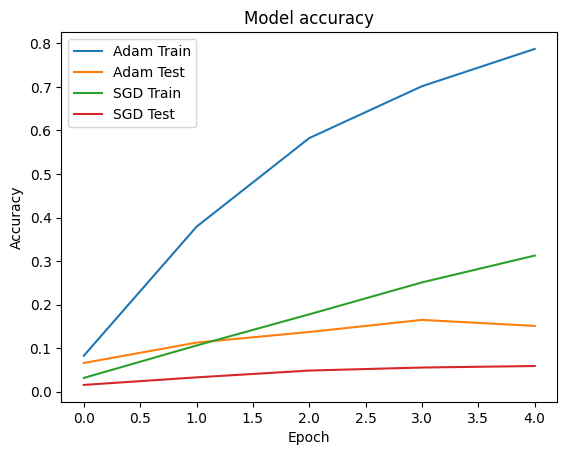

In [74]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam, label = "Adam Train")
plt.plot(val_accuracies_adam, label = "Adam Test")

plt.plot(accuracies_sgd, label = "SGD Train")
plt.plot(val_accuracies_sgd, label = "SGD Test")

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
plt.savefig('output/model_acc1.png')

### Loss values

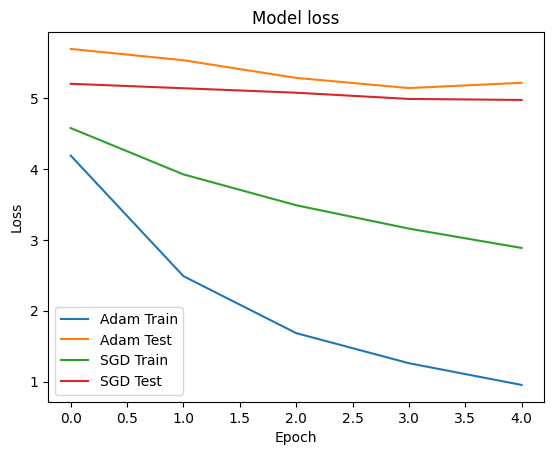

In [75]:
# Plot training & validation loss values
plt.plot(losses_adam, label = "Adam Train")
plt.plot(val_losses_adam, label = "Adam Test")

plt.plot(losses_sgd, label = "SGD Train")
plt.plot(val_losses_sgd, label = "SGD Test")

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
plt.savefig('output/model_loss1.png')

In [76]:
# import time
# timestr = time.strftime("%Y%m%d-%H%M%S") # e.g: 20181109-180140
# model_adam.save('painters_adam_e45_'+timestr+'.h5')

In [ ]:
# timestr = time.strftime("%Y%m%d-%H%M%S") # e.g: 20181109-180140
# model_sgd.save('painters_adam_e45_'+timestr+'.h5')

# Predict the output 🔮 🎩

In [94]:
test_gen

In [92]:
PRED_STEPS = len(test_gen) # 100 # default would have been len(test_gen)

In [93]:
PRED_STEPS

0

In [99]:
# Need to reset the test_gen before calling predict_generator
# This is important because forgetting to reset the test_generator results in outputs with a weird order.
test_gen.reset()
pred_adam = model_adam.predict(test_gen)

ValueError: Must provide at least one structure

In [ ]:
print(len(pred_adam),"\n",pred_adam)

In [ ]:
predicted_class_indices_adam = np.argmax(pred_adam,axis=1)

In [ ]:
def retrieve_results(predicted_class_indices, train_gens):
    print(len(predicted_class_indices),"\n",predicted_class_indices)
    print("it has values ranging from ",min(predicted_class_indices),"...to...",max(predicted_class_indices))
    labels = (train_gens[0].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print("*"*20+"\nclass_indices\n"+"*"*20+"\n",train_gens[0].class_indices,"\n")
    print("*"*20+"\nlabels\n"+"*"*20+"\n",labels,"\n")
    print("*"*20+"\npredictions has", len(predictions),"values that look like","'"+str(predictions[0])+"' which is the first prediction and corresponds to this index of the classes:",train_gens[0].class_indices[predictions[0]])
    # Save the results to a CSV file.
    filenames=test_gen.filenames[:len(predictions)] # because "ValueError: arrays must all be same length"

    real_artists = []
    for f in filenames:
        real = test_df[test_df['new_filename'] == f].artist.get_values()[0]
        real_artists.append(real)

    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions,
                        "Real Values":real_artists})
    results.to_csv("results.csv",index=False)

    return results

## Adam

In [ ]:
results_adam = retrieve_results(predicted_class_indices_adam, train_gens)

In [ ]:
results_adam.head()

In [ ]:
len(training_set_artists)

In [ ]:
print(training_set_artists)

In [ ]:
def testing_new_images(results, training_set_artists):  
    count = 0
    match = 0
    unexpected_count = 0
    unexpected_match = 0
    match_both_expected_unexpected = 0

    for p, r in zip(results['Predictions'], results['Real Values']):
        if r in training_set_artists:
            count += 1
            if p == r:
                match += 1
        else:
            unexpected_count += 1
            if p == r:
                unexpected_match += 1

    print("test accuracy on new images for TRAINED artsits")
    acc = match/count
    print(match,"/",count,"=","{:.4f}".format(acc))

    print("test accuracy on new images for UNEXPECTED artsits")
    u_acc = unexpected_match/unexpected_count
    print(unexpected_match,"/",unexpected_count,"=","{:.4f}".format(u_acc))

    print("test accuracy on new images")
    total_match = match+unexpected_match
    total_count = count+unexpected_count
    total_acc = (total_match)/(total_count)
    print(total_match,"/",total_count,"=","{:.4f}".format(total_acc))

In [ ]:
testing_new_images(results_adam, training_set_artists)

## SGD

In [ ]:
test_gen.reset()
pred_sgd = model_sgd.predict_generator(test_gen, verbose=1, steps=PRED_STEPS)
print(len(pred_sgd),"\n",pred_sgd)

In [ ]:
predicted_class_indices_sgd = np.argmax(pred_sgd,axis=1)

In [ ]:
results_sgd = retrieve_results(predicted_class_indices_sgd, train_gens)
results_sgd.head()

In [ ]:
print(len(training_set_artists))
print(training_set_artists)

In [ ]:
testing_new_images(results_sgd, training_set_artists)

So, it seems like the model may have learned some interesting patterns related to the artists that it expects. 

**Questions to explore:**
* [What does the model actually "see"](https://arxiv.org/abs/1312.6034) in a painting by [Pablo Picasso](https://www.wikiart.org/en/pablo-picasso/) as opposed to [Vincent van Gogh](https://www.wikiart.org/en/vincent-van-gogh)?
* What would happen if we trained the model on the full artist dataset or at least on artists with over 200 paintings in the dataset?
* Can the accuracy be improved with techniques like data augmentation or with a custom convolutional neural network? How about doing transfer learning with different [pre-trained model](https://keras.io/applications)?
* How can the learning rate be tuned to improve the accuracy?
* Would a regularization technique like [dropout](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) be helpful?
* This notebook uses the [Adam](https://keras.io/optimizers/#adam) optimizer... what if we tried RMSprop?
* How about using an [ensemble of models](https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/)?